# "NLP Approach using Word Embedding"

This is a minimal yet very powerful approach of NLP problems that you can use on Kaggle competition. I got my attention to the book written by one of Kaggle Grandmaster in his book called [Approaching (Almost) Any Machine Learning Problem](https://www.amazon.com/Approaching-Almost-Machine-Learning-Problem-ebook/dp/B089P13QHT). I am so interested in how the author approaches the problems for each case in Kaggle Competition started by Supervised and Unsuperviced problems. So, NLP is one of the problems in the competition in Kaggle. We know that many approaches that we can do to preprocess text data from Bag of Words, TFIDF to Word Embedding. I am interested to dive deeper into Word Embedding because this approach yield a  better result compared to BOW or Tfidf approach based on this dataset. You can find the comparison by reading this book. I found this approach quite useful for my NLP competition. Before reading this NLP approach, I hope the readers have the fundamentals concepts of pytorch, data visualization libraries and NLP concept to know the code better. 

## Import Data

In [2]:
import pandas as pd 
movies = pd.read_csv("imdb.csv")
movies.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


## Check Proportion of target 

<AxesSubplot:>

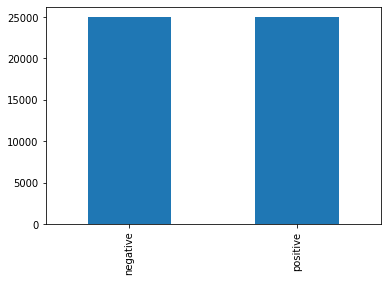

In [3]:
movies.sentiment.value_counts().plot(kind="bar")

## Create Cross Validation 

In [6]:
import pandas as pd 
from sklearn import model_selection 

if __name__=="__main__":
    df = pd.read_csv("imdb.csv")
    df.sentiment = df.sentiment.apply(lambda x: 1 if x == "positive" else 0)
    
    df["kfold"] =-1
    df = df.sample(frac=1).reset_index(drop=True)
    
    y = df.sentiment.values
    
    kf = model_selection.StratifiedKFold(n_splits=5)
    
    for f,(t_,v_) in enumerate(kf.split(X=df,y=y)):
        df.loc[v_,"kfold"] =f
        
    df.to_csv("imdb_folds.csv",index=False)
    

In [4]:
movies_folds = pd.read_csv("imdb_folds.csv")
movies_folds.head()

,review,sentiment,kfold
0,I enjoyed Erkan & Stefan  a cool and fast sto...,1,0
1,The only reason I rated this film as 2 is beca...,0,0
2,One of those movies where you take bets on who...,0,0
3,This series was just like what you would expec...,1,0
4,While many people found this film simply too s...,1,0


There is one additional features called kfold.

## Word Embedding

In [7]:
import numpy as np 

def sentence_to_vec(s,embedding_dict,stop_words,tokenizer):
    words =str(s).lower()
    words =tokenizer(words)
    words = [ w for w in words if w not in stop_words]
    
    words = [w for w in words if w.alpha()]
    
    M =[]
    for w in words:
        if w in embedding_dict:
            M.append(embedding_dict[w])
            
    if len(M)==0:
        return np.zeros(300)
    M = np.array(M)
    v = M.sum()

    
    return v/np.sqrt((v**2).sum())

## Create Dataset in pytorch based on model in our dataset

In [8]:
import torch 

class IMDBDataset:
    def __init__(self,reviews,targets):
        self.reviews =reviews
        self.targets = targets
        
    def __len__(self):
        return len(self.reviews)
    
    def __getitem__(self,item):
        review =self.reviews[item,:]
        target =self.target[item]
        
        return {
            "review": torch.tensor(review,dtype=torch.long),
            "target": torch.tensor(target,dtype=torch.float)
        }


## Create Model

In [9]:
import torch.nn as nn 
class LSTM(nn.Module):
    def __init__(self,embedding_matrix):
        super(LSTM,self).__init__()
        
        num_words =embedding_matrix.shape[0]
        
        embed_dim= embedding_matrix.shape[1]
        
        self.embedding = nn.Embedding(
            num_embeddings = num_words,
            embedding_dim=embed_dim
        )
        
        self.embedding.weight = nn.Parameter(
            torch.tensor(
                embedding_matrix,
                dtype=torch.float32
            )
        )
        
        self.embedding.weight.requires_grad=False
        
        self.lstm = nn.LSTM(
            embed_dim,
            128,
            bidirectional=True,
            batch_first=True
        )
        
        self.out = nn.Linear(512,1)
        
    def forward(self,x):
        x = self.embedding(x)
            
        x,_ = self.lstm(x)
        avg_pool =torch.mean(x,1)
        max_pool, _ = torch.max(x,1)
            
        out = torch.cat((avg_pool,maxpool),1)
        out = self.out(out)
            
        return out

## Create Training Function for Modelling

In [10]:
def train(data_loader,model,optimizer,device):
    model.train()
    
    for data in data_loader:
        reviews = data["review"]
        targets = data["target"]
    
        reviews = reviews.to(device,dtype=torch.long)
        targets = targets.to(device,dtype=torch.float)
        
        optimizer.zero_grad()
        
        predictions = model(reviews)
        
        loss =nn.BCEWithLogitsLoss()(
            predictions,
            targets.view(-1,1)
        )
        
        loss.bakward()
        optimizer.step()

## Create Evaluation for Modelling

In [11]:
def evaluate(data_loader,model,device):
    final_predictions =[]
    final_targets = []
    
    model.eval()
    
    with torch.no_grad():
        for data in data_loader:
            reviews =data["review"]
            targets =data["target"]
            reviews = reviews.to(device,dtype=torch.long)
            targets = targets.to(device,dtype=torch.long)
            
            predictions = model(reviews)
            
            predictions = predictions.cpu().numpy().tolist()
            targets = data["target"].cpu().numpy.tolist()
            final_predictions.extend(predictions)
            final_targets.extend(targets)
            
    return final_predictions,final_targets

## Word Embedding Creation

In [ ]:
import io
#from tensorflow.keras import 
import tensorflow as tf
def load_vectors(fname):
    fin = io.open(
        fname,
        "r",
        encoding="utf-8",
        newline="\n",
        errors="ignore"
    )
    n,d = map(int,fin.readline().split())
    data ={}
    for line in fin:
        tokens = line.rstrip().split(' ')
        data[tokens[0]] = list(map(float,tokens[1:]))
    return data

def create_embedding_matrix(world_index,embedding_dict):
    embedding_matrix = np.zeros((len(word_index)+1,300))
    for word , i in word_index.items():
        if word in embedding_dict:
            embedding_dict[i] = embedding_dict[word]
    return embedding_matrix

def run(df,fold):
    train_df = df[df.kfold != fold].reset_index(drop=True)
    valid_df = df[df.kfold ==fold].reset_index(drop=True)
    
    print("Fitting tokenizer")
    
    tokenizer = tf.keras.preprocessing.text.Tokenizer()
    tokenizer.fit_on_texts(df.review.values.tolist())
    
    xtrain = tokenizer.texts_to_sequences(train_df.review.values)
    
    xtest = tokenizer.texts_to_sequences(valid_df.review.values)
    
    xtrain = tf.keras.preprocessing.sequence.pad_sequences(
        xtrain,maxlen=128
    )
    
    xtest = tf.keras.preprocessing.sequence.pad_sequences(
        xtest,maxlen=128
    )
    
    train_dataset = IMDBDataset(
        reviews =xtrain,
        targets = train_df.sentiment.values
    )
    
    train_data_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size =16,
        num_workers=2
    
    )
    
    valid_dataset =IMDBDataset(
        reviews =xtest,
        targets = valid_df.sentiment.values
    )
    
    train_data_loader = torch.utils.data.DataLoader(
        valid_dataset,
        batch_size =8,
        num_workers=1
    )
    
    print("Loading Embeddings")
    # you can suit based on where you put your vec fasttext
    embedding_dict = load_vectors("crawl-300d-2M.vec/crawl-300d-2M.vec")
    embedding_matrix = create_embedding_matrix(
        tokenizer.word_index,embedding_dict
    )
    
    device =torch.device("cuda")
    
    model =LSTM(embedding_matrix)
    
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(),lr=1e-3)
    
    print("Training Model")
    
    best_accuracy =0
    early_stopping_counter =0
    for epoch in range(10):
        train(train_data_loader,model,optimizer,device)
        outputs,targets = evaluate(valid_data_loader,model,device)
        outputs = np.array(outputs) >=0.5
        
        accuracy = metrics.accuracy_score(targets,outputs)
        print(f"{fold}, Epoch {epoch}, Accuracy Score ={accuracy}")
        
        if accuracy > best_accuracy:
            best_accuracy = accuracy
        else:
            early_stopping_counter +=1
        if early_stopping_counter > 2:
            break
            
if __name__ == "__main__":
    df = pd.read_csv("imdb_folds.csv")
    run(df,0)
    run(df,1)
    run(df,2)
    run(df,3)
    run(df,4)
    

Fitting tokenizer
Loading Embeddings


The choice of Machine learning algorithms will determine the quality of our predictions score. However, The simple model will also determine how fast the training process compared to state of art of ML algorithms. If we have laptop/computer with better GPU can help the training process. But in real life, Simple models with better preprocessing will have predictions score that is not too dfferent with newest ML algorithms. So, It is better to discuss with the stakeholder for improving the models based on business metrics.